# Possible Business Questions
- What are our most commonly sold items?
- What is our total revenue?
- When did we sell the most?
- How do our sales trends look? Look at # sales over time, revenue over time, revenue by country, etc.
- Where do we sell the most?
- Where is most profitable to sell?
- What are our most profitable items?  Where are they sold the most?

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import mysql.connector
import os
import seaborn as sns

In [2]:
# load_dotenv()
# mysqluser = os.getenv("mysqluser")
# mysqlpassword = os.getenv("mysqlpassword")
# mysqlhost = os.getenv("mysqlhost")
# mysqldatabase = os.getenv("mysqldatabase")

# try:
#     cnx = mysql.connector.connect(user=mysqluser, password=mysqlpassword,
#                                 host=mysqlhost, database=mysqldatabase)
#     query = "SELECT * from onlineretail"
#     df = pd.read_sql(query, cnx)
#     cnx.close()
# except Exception as e:
#     cnx.close()
#     print(str(e))

Original data from https://archive.ics.uci.edu/ml/datasets/Online+Retail+II

First we downloaded the excel file from the UCI ML repo.  The sheets were then downloaded as csv and split by sheet (one for 2009-2010, the other for 2010-2011)

Next we read in these csv files to pandas dataframes, add a flag to show the original sheet, combine them, and begin data cleaning.  The flag is for checking if issues occured in reading in the csv or if they were present in the original data.  Can be removed after cleaning.


In [3]:
df1 = pd.read_csv(r"data/online_retail_II_2009_2010.csv", encoding='unicode_escape', parse_dates=['InvoiceDate'])
df1['Flag'] = 1
df2 = pd.read_csv(r"data/online_retail_II_2010_2011.csv", encoding='unicode_escape', parse_dates=['InvoiceDate'])
df2['Flag'] = 2
df = pd.concat([df1, df2])
df.reset_index(inplace=True, drop=True)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Flag
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
 8   Flag         1067371 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 73.3+ MB


In [5]:
df.columns = df.columns.str.strip().str.lower()  # Strip leading/trailing whitespace and lowercase all column names
df.rename(columns={"customer id":"customerid"}, inplace=True)  # remove whitespace in customer ID as well
df.columns

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customerid', 'country', 'flag'],
      dtype='object')

Invoice must remain as str because of ones such as 'C489449'.  
Similarly, stockcode must remain as str.  
customerid is converted to Int64 which allows for the NaN values (int alone doesn't)

In [6]:
df.customerid[0]

13085.0

The df contains 1067371 entries.  All Invoices must be non-null.  We saw that there exist nulls in Description and Customer ID.  In fact, 22% of our customer id's are missing!  This could be because other rows in the df are already tied to a customer ID by the invoice.  Should group by and examine.

In [7]:
df.isnull().sum()

invoice             0
stockcode           0
description      4382
quantity            0
invoicedate         0
price               0
customerid     243007
country             0
flag                0
dtype: int64

We can also see that there exist negative quantities of products sold and prices.  

<AxesSubplot:>

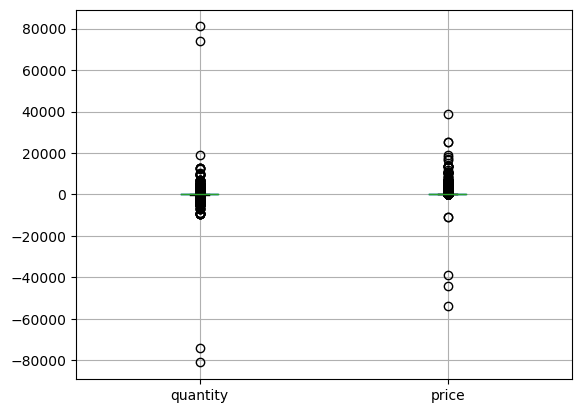

In [8]:
df.boxplot(column=['quantity', 'price'])

In [9]:
print(f"{len(df[df.quantity < 0]) / len(df) * 100:.2f}% of our quantities are negative") 
print(f"{len(df[df.price < 0]) / len(df) * 100:.2f}% of our prices are negative") 
print(f"{len(df[df.price == 0]) / len(df) * 100:.2f}% of our prices are equal to zero") 

2.15% of our quantities are negative
0.00% of our prices are negative
0.58% of our prices are equal to zero


Data has invoices prefaced with 'c' indicating that the order was cancelled.  Many of these are the places where the quantities are negative indicating a return.

In [10]:
canceldf = df[df.invoice.str.startswith('C')]  # store cancelled items

The remaining places where the quantities are negative may be misattributed as sales while actually being cancelled, but it is unclear.  As such we will discard this small amount of data along with places where the prices are equal to zero (<1% of the total data)

In [11]:
df = df[df.quantity > 0]  # Get rid of zero or negative quantity orders
df = df[df.price > 0]  # Get rid of zero or negative price orders

In [12]:
df[df.customerid.isna()]

,invoice,stockcode,description,quantity,invoicedate,price,customerid,country,flag
577,489525,85226C,BLUE PULL BACK RACING CAR,1,2009-12-01 11:49:00,0.55,NaN,United Kingdom,1
578,489525,85227,SET/6 3D KIT CARDS FOR KIDS,1,2009-12-01 11:49:00,0.85,NaN,United Kingdom,1
1055,489548,22271,FELTCRAFT DOLL ROSIE,1,2009-12-01 12:32:00,2.95,NaN,United Kingdom,1
1056,489548,22254,FELT TOADSTOOL LARGE,12,2009-12-01 12:32:00,1.25,NaN,United Kingdom,1
1057,489548,22273,FELTCRAFT DOLL MOLLY,3,2009-12-01 12:32:00,2.95,NaN,United Kingdom,1
...,...,...,...,...,...,...,...,...,...
1066997,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom,2
1066998,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom,2
1066999,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom,2
1067000,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom,2


Below cell shows that it isn't the case that the customerid's were bunched up by invoice.  Seems to just be a lot of missing data.

In [13]:
# Takes a long time to run
# i = 0
# bucket = []
# for inv in df[df.customerid.isna()].invoice:
#     if i % 5000 == 0:
#         print(f"{i/238796*100}% Done")
#     if len(df[(df.invoice == inv) & ~(df.customerid.isna())]) > 0:
#         print(inv)
#         bucket.append(inv)
#     i += 1
# bucket

Much of our analysis can be done even without the customerid being known, but some requires it.  As such we'll keep the orignal df while also creating two smaller copies where the customerid is either known or not - these can be used to answer business questions that require knowing the customerid.

In [14]:
# df.reset_index(inplace=True)  
# noCustdf = df[df.customerid.isna()]  # dataframe for the large amount of data (~23%) where the customerid is unknown
# withCustdf = df[~df.index.isin(noCustdf.index)]  # drop rows from df based on index of noCustdf

In [15]:
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customerid,country,flag
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1


### Business Question 1:  
What are our most commonly sold items?

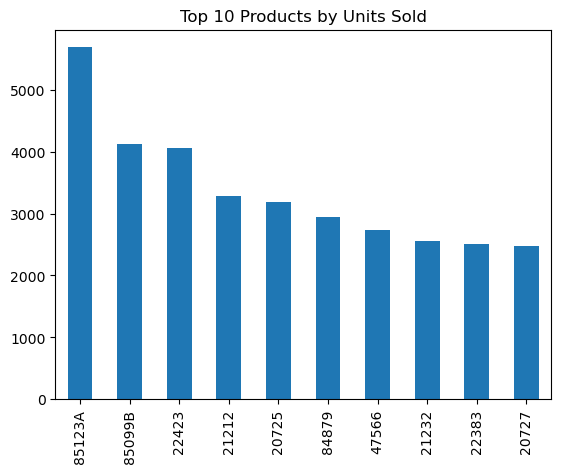

In [16]:
df.stockcode.value_counts()[:10].plot(kind='bar', title='Top 10 Products by Units Sold');
plt.show()

### Business Question 2:
What is our total revenue?

In [17]:
print(df.invoicedate.min(), df.invoicedate.max())

2009-12-01 07:45:00 2011-12-09 12:50:00


In [18]:
df['revenue'] = df.quantity * df.price

In [19]:
print(f"Our total revenue is {df.revenue.sum():.2f} pound sterling")

Our total revenue is 20972968.14 pound sterling


### Business Question 3:
When did we sell the most?

In [20]:
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customerid,country,flag,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,1,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1,30.0


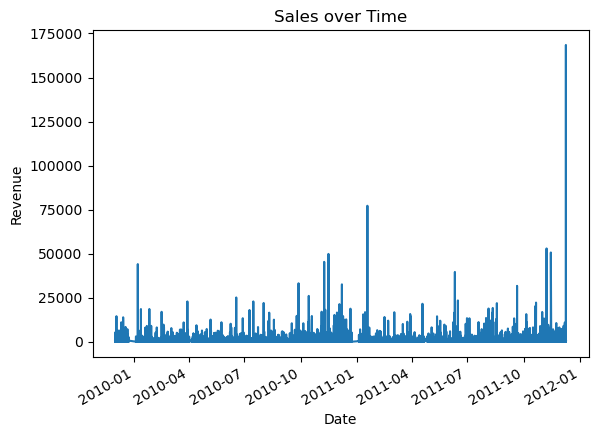

In [21]:
ax = df.groupby("invoicedate").sum().revenue.plot()
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Sales over Time")
plt.show()
fig = ax.get_figure()
fig.savefig(r"data/imgs/salesOverTime.png")

We can also make a nicer, easier to follow graph looking at the sales by month

In [22]:
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customerid,country,flag,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,1,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1,30.0


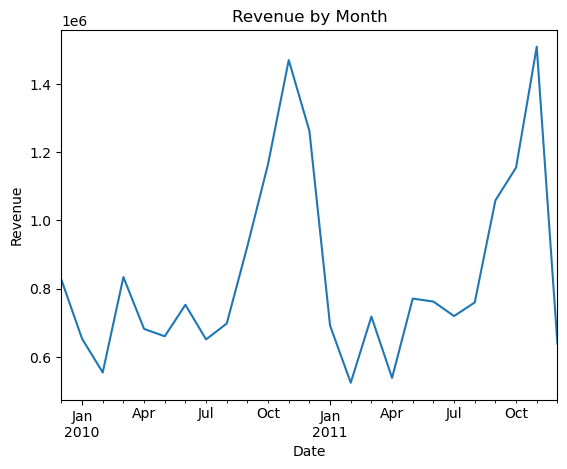

In [23]:
ax = df.resample(rule='M', on='invoicedate')['revenue'].sum().plot();
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.title("Revenue by Month")
plt.show();
fig = ax.get_figure()
fig.savefig(r"data/imgs/revByMonth.png")


We can see that our top sales were at the start of 2012, with some notable peaks around the start of 2011 and 2010.  Clearly the start of the year is an important time for the business, and we can see that sales are trending upwards.

### Business Question 4:
How do our sales trends look? Look at # sales over time, revenue over time, revenue by country, etc.

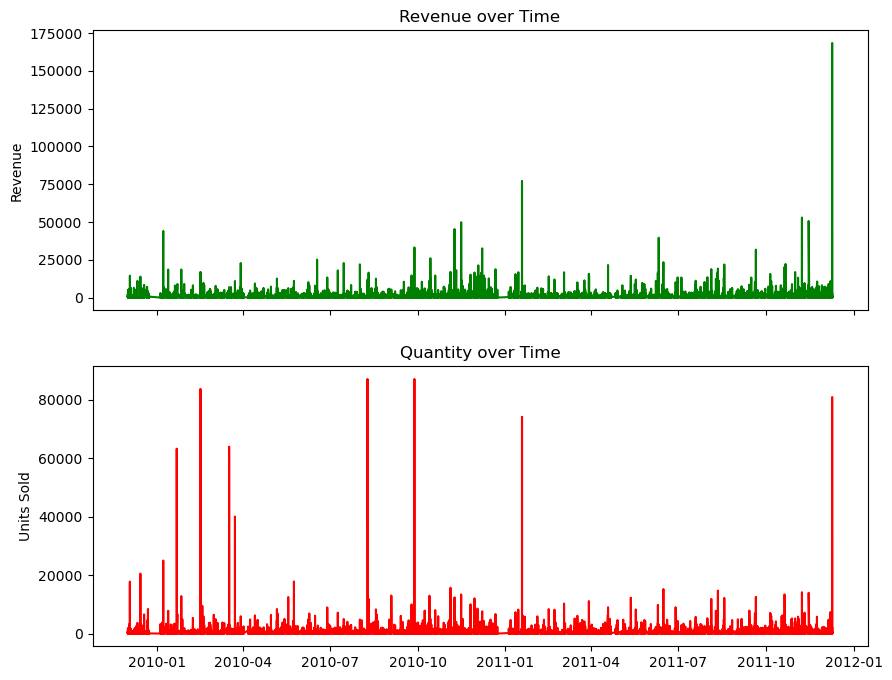

In [24]:
fig, axs = plt.subplots(2,1, figsize=(10,8), sharex=True)
# df.groupby("invoicedate").sum().revenue.plot(ax=axes[0])
# df.groupby("invoicedate").sum().quantity.plot(ax=axes[1])
axs[0].plot(df.groupby("invoicedate").sum().revenue, c='green');
axs[0].set_title("Revenue over Time")
axs[0].set_ylabel("Revenue")
axs[1].plot(df.groupby("invoicedate").sum().quantity, c='red');
axs[1].set_title('Quantity over Time')
axs[1].set_ylabel("Units Sold")
plt.show();

The third part of this business question can generate a lot of results since we have sales to so many different countries.  As such a small function is made which can take in the countries of interest and return plots thereof, rather than showing all of the plots at once.  An example is given with the top 5 countries by revenue.

In [25]:
top6Countries = df.groupby(["country"]).sum().revenue.nlargest(6).keys()  # Get top 5 countries' names, sorted by sum of revenues.
top6Countries

Index(['United Kingdom', 'EIRE', 'Netherlands', 'Germany', 'France',
       'Australia'],
      dtype='object', name='country')

In [26]:
def showCountrySales(countries, n=2, setShareY=False):
    """
    Small function to plot country revenue over time
    
    args:
        countries (list): List of contries to plot revenue over time for
        n (int): Skip every n'th xlabel for cleaner graphs.  Default skips every other one.
        setShareY (bool): Set if you want the y axes to be shared.  Off by default due to UK dominating in our example
    """
    fig, axs = plt.subplots((len(countries))//3, 3, figsize=(20,5), sharex=True, sharey=setShareY)
    grouped = df.groupby(["country","invoicedate"]).sum().revenue
    for country, ax in zip(countries, fig.axes):
        ax.plot(grouped[country]);
        plt.setp(ax.get_xticklabels()[::n], visible=False)
        ax.set_xlabel(country)
    fig = ax.get_figure()
    fig.savefig(r"data/imgs/salesByCountry.png")
    plt.show()

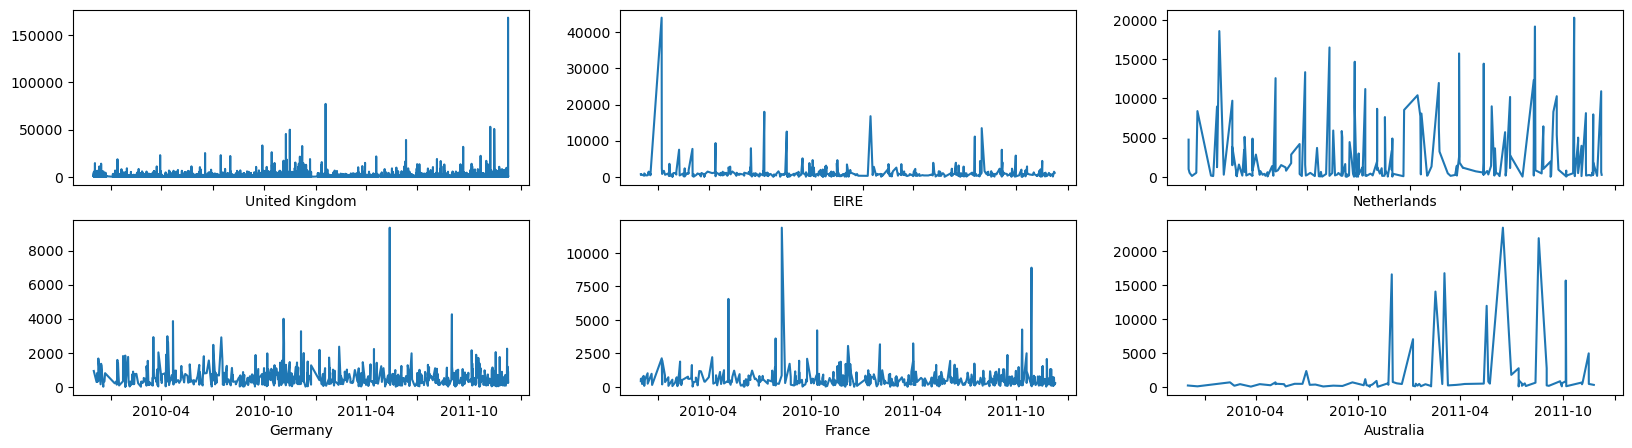

In [27]:
showCountrySales(top6Countries)

We see some interesting spikes in quantity sold that don't directly correlate to revenue.  We can also see some interesting trends in our revenue over time by country - even just within our top 6 contries.  There are some interesting things to look at sales by country but they will be addressed further in other business questions, so we'll move on from here.

### Business Question 5:
Where do we sell the most?

In [28]:
n=5
topNRevenue = df.groupby(["country"]).sum().revenue.nlargest(n)
topNQuantity = df.groupby(["country"]).sum().quantity.nlargest(n)
print(f"Our top {n} countries by revenue are: {topNRevenue.keys().values} selling {topNRevenue.values} streling respectively")
print(f"Our top {n} countries by quantity sold are {topNQuantity.keys().values} selling {topNQuantity.values} units respectively")

Our top 5 countries by revenue are: ['United Kingdom' 'EIRE' 'Netherlands' 'Germany' 'France'] selling [17871351.347   664431.78    554232.34    431262.461   356944.6  ] streling respectively
Our top 5 countries by quantity sold are ['United Kingdom' 'Netherlands' 'EIRE' 'France' 'Denmark'] selling [9383245  383977  340289  275287  237925] units respectively


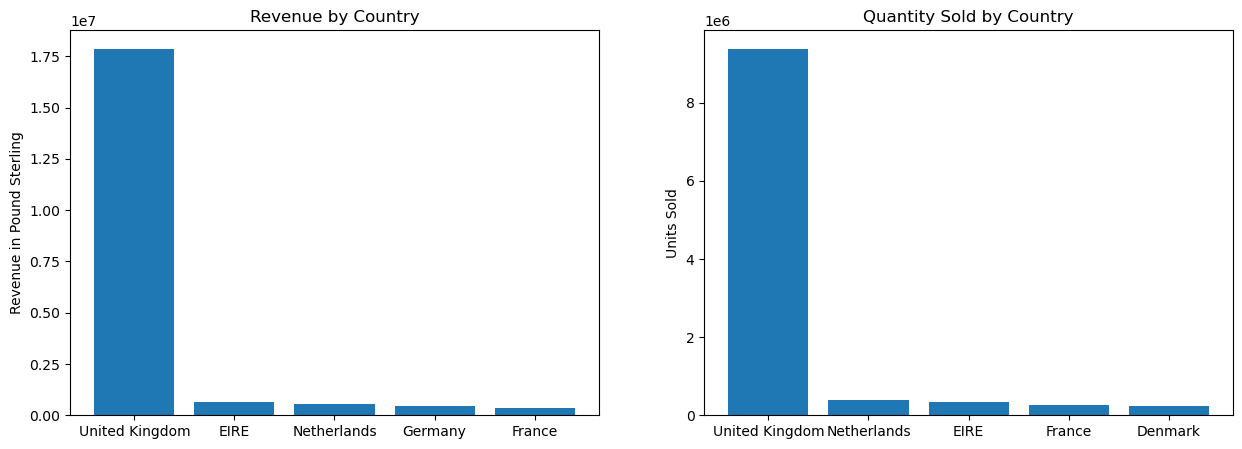

In [29]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].bar(topNRevenue.keys(), topNRevenue.values);
axes[0].set_title("Revenue by Country")
axes[0].set_ylabel("Revenue in Pound Sterling")
axes[1].bar(topNQuantity.keys(), topNQuantity.values);
axes[1].set_title("Quantity Sold by Country")
axes[1].set_ylabel("Units Sold")
fig.savefig(r"data/imgs/revAndQuantByCountry.png")
plt.show()

Clearly the UK dominates here.  Plots below show the same plots as above but without the UK to get a better sense of how quickly they fall off.

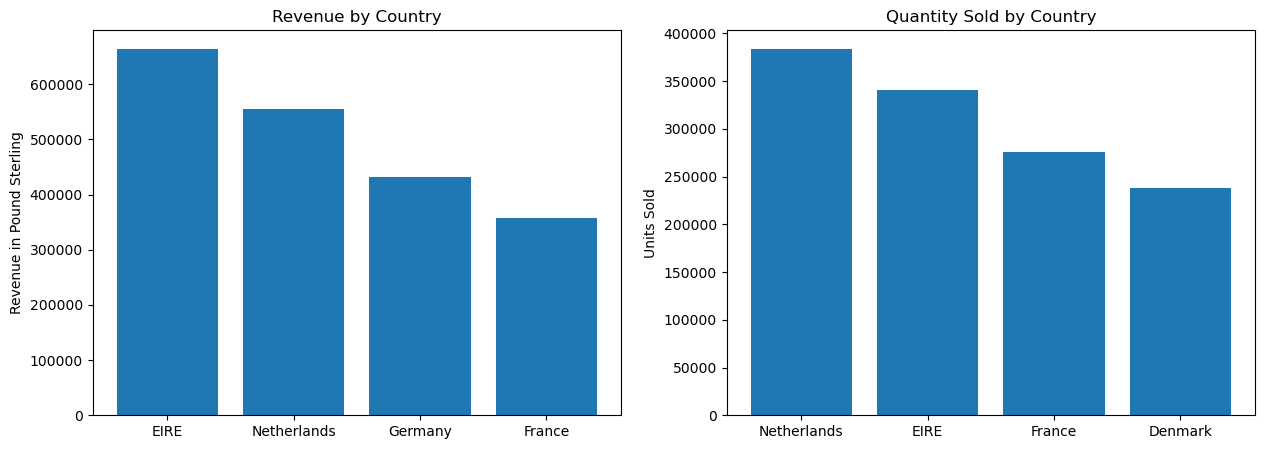

In [30]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].bar(topNRevenue.keys()[1:], topNRevenue.values[1:]);
axes[0].set_title("Revenue by Country")
axes[0].set_ylabel("Revenue in Pound Sterling")
axes[1].bar(topNQuantity.keys()[1:], topNQuantity.values[1:]);
axes[1].set_title("Quantity Sold by Country")
axes[1].set_ylabel("Units Sold")
fig.savefig(r"data/imgs/revAndQuantByCountryNOUK.png")
plt.show()

Clearly we sell the most both by revenue generated and quantity sold in the UK.  After that, we generate the most revenue in Ireland but sell more quantity in the Netherlands.

### Business Question 6:
Where is most profitable to sell?

From our previous analysis, it is clear that focusing on the UK is our bread and butter.  Past this though, Ireland and the Netherlands are our best bets.  Ireland seems to buy higher priced items at a slightly lower quantity than the Netherlands, but the Netherlands likes to buy a larger quantity of lower priced goods.

### Business Question 7:
What are our most profitable items?  Where are they sold the most?

Unfortunately, we do not have data on the cost of goods sold or anything of the sort, so we will answer this one to the best of our ability by looking at revenue generated and quantity sold.

In [31]:
n=15
topNItemRev = df.groupby(["stockcode"]).sum().revenue.nlargest(n)
topNItemQuant = df.groupby(["stockcode"]).sum().quantity.nlargest(n)
# print(f"Our top {n} items by revenue are: {topNItemRev.keys().values}\n" 
#       f"selling {topNItemRev.values} streling respectively"
#       f"Our top {n} items by quantity sold are {topNItemQuant.keys().values}\n"
#       f"selling {topNItemQuant.values} units respectively")

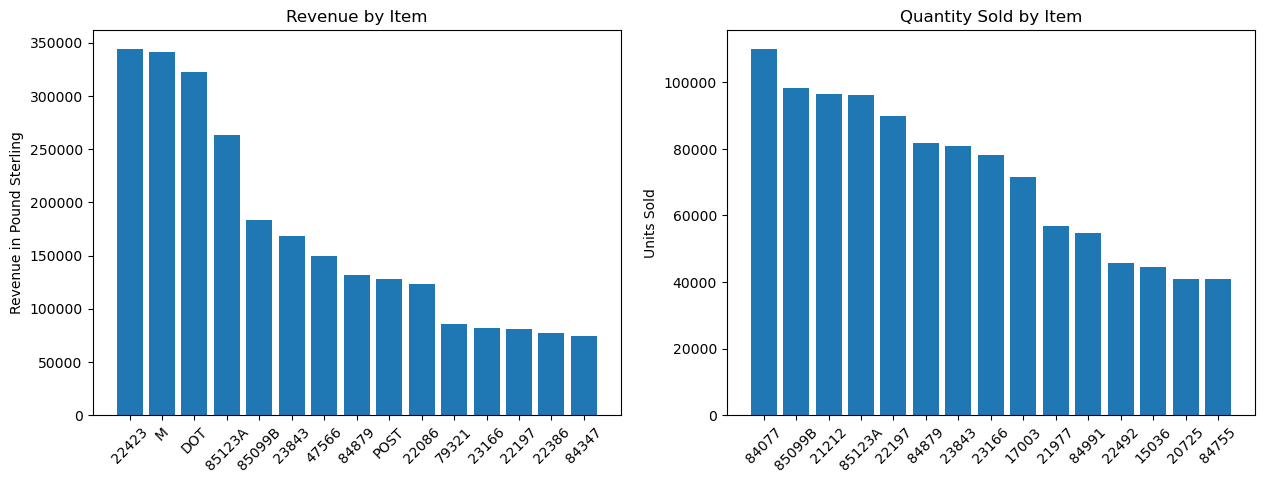

In [32]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
axes[0].bar(topNItemRev.keys(), topNItemRev.values);
axes[0].set_title("Revenue by Item")
axes[0].set_ylabel("Revenue in Pound Sterling")
axes[0].tick_params('x', labelrotation=45);
axes[1].bar(topNItemQuant.keys(), topNItemQuant.values);
axes[1].set_title("Quantity Sold by Item")
axes[1].set_ylabel("Units Sold")
axes[1].tick_params('x', labelrotation=45);
fig.savefig(r"data/imgs/revQuantByItem.png")
plt.show();

It is unclear if M, DOT, POST are 'real' items or placeholders/flags.  Since we do not know, they will be treated as real item stock codes.  If, upon future knowledge, they end up not being real item stock codes, they could be easily taken out of this analysis.  As it stands, we can see that our top selling items by quantity are not actually our top selling items by revenue.  This makes sense on the face of it e.g. selling a battery vs. selling an oven.  Clearly more batteries would be sold but the oven would generate more revenue.  Lets get a bit more in depth and see if there are any overlaps in quantity and revenue near the top.

In [33]:
def findMatches(n=15):
    topNItemRevCodes = set(df.groupby(["stockcode"]).sum().revenue.nlargest(n).keys())
    topNItemQuantCodes = set(df.groupby(["stockcode"]).sum().quantity.nlargest(n).keys())
    if (topNItemRevCodes & topNItemQuantCodes):
        return(topNItemRevCodes & topNItemQuantCodes)
    else:
        print("No Common Stock Codes")

In [34]:
for stockCode in list(findMatches(n=15)):
    print(f"For item {stockCode}, {df.groupby(['stockcode']).sum().quantity[stockCode]} items were sold for a total of {df.groupby(['stockcode']).sum().revenue[stockCode]:.2f} pound Sterling")

For item 85123A, 96147 items were sold for a total of 263109.67 pound Sterling
For item 22197, 89898 items were sold for a total of 80920.64 pound Sterling
For item 23843, 80995 items were sold for a total of 168469.60 pound Sterling
For item 23166, 78033 items were sold for a total of 81700.92 pound Sterling
For item 84879, 81809 items were sold for a total of 132187.92 pound Sterling
For item 85099B, 98349 items were sold for a total of 183454.83 pound Sterling


In [35]:
matchRev = df.groupby(["stockcode"]).sum().revenue[list(findMatches(n=15))].sort_values(ascending=False)
matchQuant = df.groupby(["stockcode"]).sum().quantity[list(findMatches(n=15))]

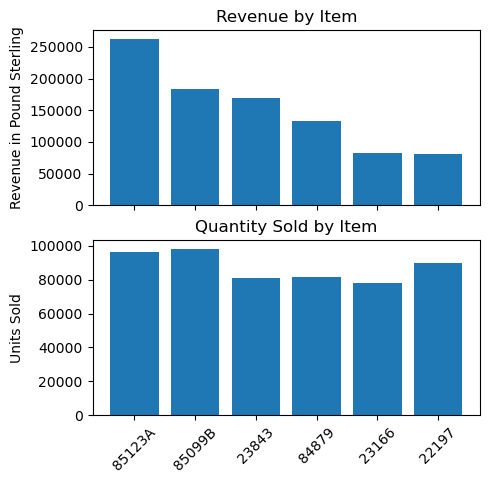

In [36]:
fig, axes = plt.subplots(2,1, figsize=(5,5), sharex=True)
axes[0].bar(matchRev.keys(), matchRev.values);
axes[0].set_title("Revenue by Item")
axes[0].set_ylabel("Revenue in Pound Sterling")
axes[0].tick_params('x', labelrotation=45);
axes[1].bar(matchQuant.keys(), matchQuant.values);
axes[1].set_title("Quantity Sold by Item")
axes[1].set_ylabel("Units Sold")
axes[1].tick_params('x', labelrotation=45);
fig.savefig(r"data/imgs/topItemRevQuant.png")
plt.show();

We can see that though we sell a similar amount of 85099B as 85123A, the revenue produced by the latter is much higher.  Also, though we sell less of 23843 as compared to 85099B, we make a similar amount of revenue.  As such we should clearly focus on 85123A as it generates a large amount of revenue while also selling in large quantities, but we may want to focus on 23843 over 85099B due to the previously mentioned descrepancies between units sold and revenue.  

All that said, this is a difficult analysis to make without knowledge of the cost of producing each of these items.  As such we'll leave it there for this part of the business question.

Finally, we will look at where these top selling items are actually sold.

In [37]:
top5ItemCountry = df.groupby(["stockcode", "country"]).sum().revenue[list(findMatches(n=15))].groupby(level=0, group_keys=False).nlargest(5)

We plot the top 5 countries' revenues by item below.  Clearly, the UK beats out all the rest.  This makes sense as we've already seen that the UK was our top market.  This drives home that fact and shows that it holds true for all of our top selling items.

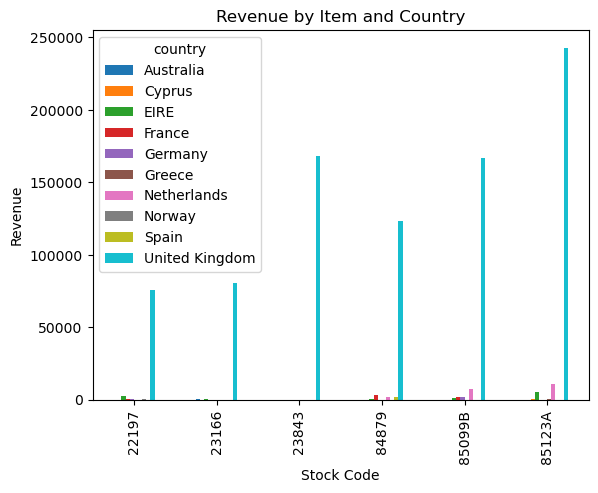

In [38]:
top5ItemCountry.unstack().plot(kind='bar');
plt.title("Revenue by Item and Country")
plt.xlabel("Stock Code")
plt.ylabel("Revenue")
plt.show();

While it is unsurprising that the UK is the top, it does answer our business question.  The UK is where our top items are sold.

## Additional Business Question(s)
added later, must reformat notebook after completion

Customer retention

In [39]:
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customerid,country,flag,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,1,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,1,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,1,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,1,30.0


In [40]:
earliestdf = df.groupby('customerid').invoicedate.min().reset_index()
earliestdf.columns = ['customerid', 'earliestpurchasedate']
df2 = df.copy()
df2 = pd.merge(df2, earliestdf, on='customerid')
df2['custstatus'] = 'New'  # default each purchase to have the customer be 'new'
df2.loc[df2['invoicedate'] > df2['earliestpurchasedate'], 'custstatus'] = 'Existing'  # If the invoice is later than the earliest purchase, that is an order from an existing customer

In [41]:
revByStatus = df2.groupby(['invoicedate', 'custstatus'])['revenue'].sum().reset_index()  # New df to store grouped revenue by customer status
revNew = revByStatus[revByStatus.custstatus=='New'].resample(rule='M', on='invoicedate')['revenue'].sum().reset_index()  # Group by month and sum revenue within each month for new custs
revExisting = revByStatus[revByStatus.custstatus=='Existing'].resample(rule='M', on='invoicedate')['revenue'].sum().reset_index()  # as above but for existing custs

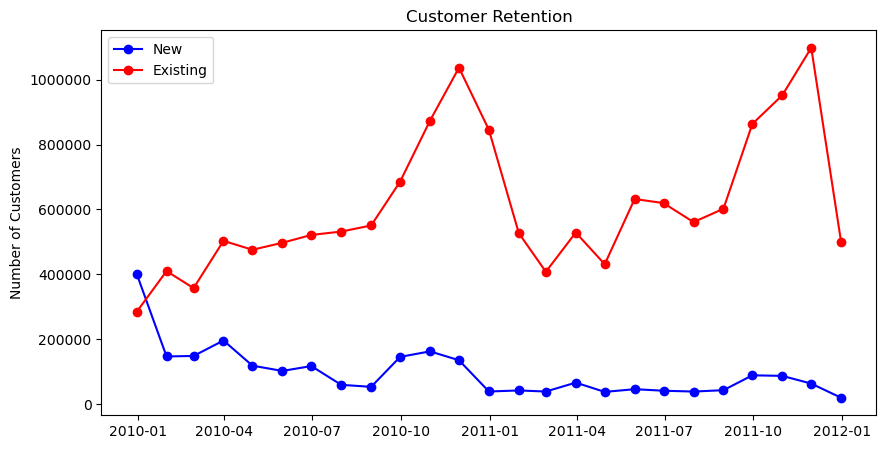

In [43]:
plt.figure(figsize=(10,5));
plt.plot(revNew.invoicedate, revNew.revenue, '-o', c='b', label='New');
plt.plot(revExisting.invoicedate, revExisting.revenue, '-o', c='r', label='Existing');
plt.title("Customer Retention");
plt.legend();
plt.ticklabel_format(style='plain', axis='y');
plt.ylabel("Number of Customers")
plt.show()

We can see that our number of existing customers seems to on an okay - slightly positive - trend, but we see a slightly negative slope to the trend in our new customers.  This seems to show that we are okay keeping existing methods of customer retention going, but should perhaps put more effort into finding new customers.

## Moving on to Modeling
We've now answered some important business questions using the base data.  This could be done in Python as we did, or using Tableau or any number of other ways.  We will now focus on modeling to help answer previous questions more in-depth, and perhaps answer some new ones.  

In [118]:
df3 = df[df.country == 'United Kingdom'].resample(rule='M', on='invoicedate')['revenue'].sum().reset_index()
df3.columns = ['invoicebymonth', 'revenue']
df3.head()  # df for revenue by month in the UK

,invoicebymonth,revenue
0,2009-12-31,750317.220
1,2010-01-31,511797.662
2,2010-02-28,455136.286
3,2010-03-31,721530.211
4,2010-04-30,584609.731


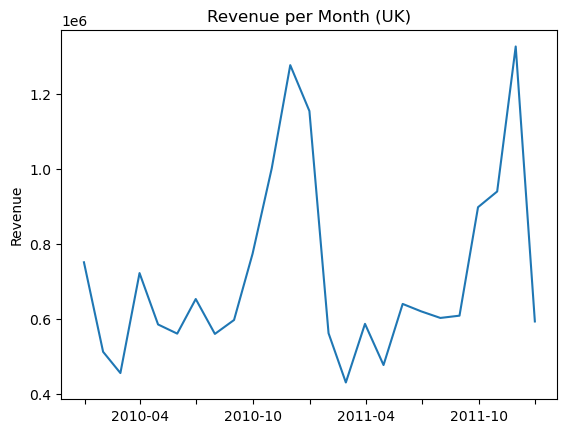

In [119]:
fig, ax = plt.subplots();
plt.plot(df3.invoicebymonth, df3.revenue);
plt.setp(ax.get_xticklabels()[::2], visible=False);  # Skip every other xtick label
plt.title("Revenue per Month (UK)")
plt.ylabel("Revenue")
plt.show();

Honestly not that clear of a trend, no easily identifiable cyclicality.  Let's examine some more possible date features.  First, we must create these features.

#### This could probably be brought up earlier, should do so when we reformat the notebook

In [174]:
def makeTimeFeatures(df):
    df = df.copy()
    df['dayofweek'] = df['invoicedate'].dt.dayofweek
    df['month'] = df['invoicedate'].dt.month
    df['quarter'] = df['invoicedate'].dt.quarter
    df['year'] = df['invoicedate'].dt.year
    df['dayofyear'] = df['invoicedate'].dt.dayofyear
    df['dayofmonth'] = df['invoicedate'].dt.day
    df['weekofyear'] = df['invoicedate'].dt.weekofyear
    df['season'] = pd.cut(df['invoicedate'].dt.month, [0, 3, 6, 9, 12], labels=['Winter', 'Spring', 'Summer', 'Fall'])  # Rough season cutoffs
    return df

In [177]:
timedf = makeTimeFeatures(df[df.country == 'United Kingdom'][['invoicedate', 'revenue']])
timedf['dayofweek'] = [x.strftime('%A') for x in timedf.invoicedate]  # Replace the day numbers with day names.  Could change in function, but this is mostly for the plot
timedf.head()

C:\Users\Zade\AppData\Local\Temp\ipykernel_18048\3663122141.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['invoicedate'].dt.weekofyear


,invoicedate,revenue,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,season
0,2009-12-01 07:45:00,83.4,Tuesday,12,4,2009,335,1,49,Fall
1,2009-12-01 07:45:00,81.0,Tuesday,12,4,2009,335,1,49,Fall
2,2009-12-01 07:45:00,81.0,Tuesday,12,4,2009,335,1,49,Fall
3,2009-12-01 07:45:00,100.8,Tuesday,12,4,2009,335,1,49,Fall
4,2009-12-01 07:45:00,30.0,Tuesday,12,4,2009,335,1,49,Fall


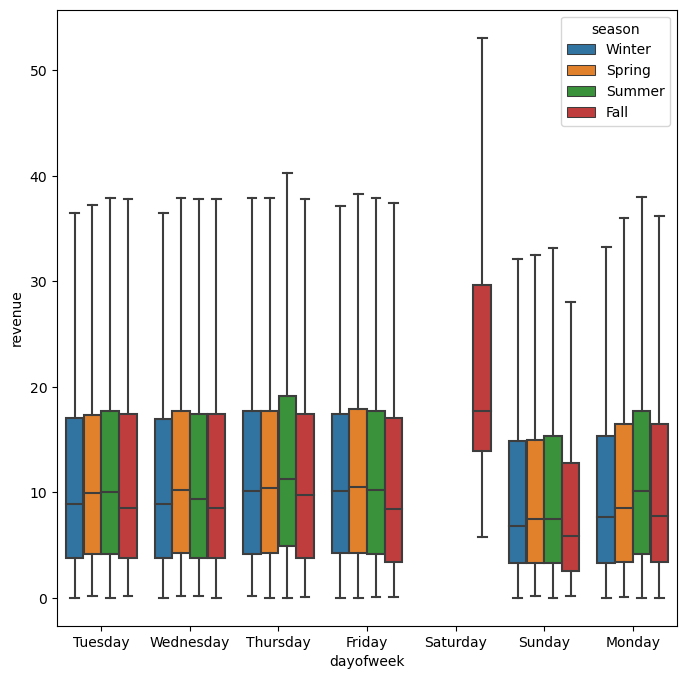

In [181]:
fig, ax = plt.subplots(figsize=(8,8))
sns.boxplot(data=timedf, x='dayofweek', y='revenue', hue='season', ax=ax, showfliers=False);  # If we don't exclude outliers the plots are useless.
plt.show();

Can see that there seems to be a dirth of sales on Saturday, as well as lower sales on Sunday.  There also seems to be a little bit of seasonality with slightly lower sales in Fall.

### Try Prophet

In [192]:
train = df3.iloc[1:19]
test = df3.iloc[19:]  # split it 75% train, 25% test by date

In [200]:
train

,invoicebymonth,revenue
1,2010-01-31,511797.662
2,2010-02-28,455136.286
3,2010-03-31,721530.211
4,2010-04-30,584609.731
5,2010-05-31,560187.810
6,2010-06-30,652412.490
7,2010-07-31,559442.540
8,2010-08-31,596550.350
9,2010-09-30,773073.501
10,2010-10-31,1000408.880


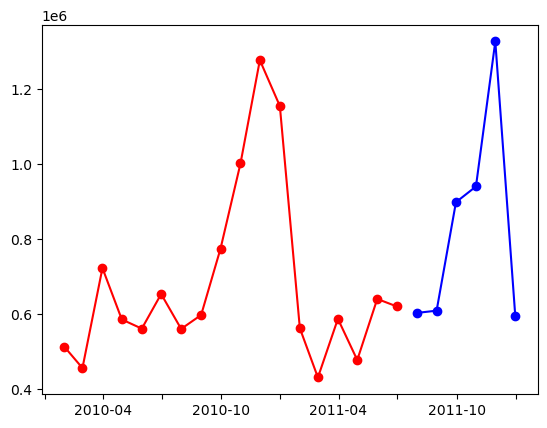

In [210]:
fig, ax = plt.subplots();
ax.plot(train.invoicebymonth, train.revenue, '-o', color='red');
ax.plot(test.invoicebymonth, test.revenue, '-o', color='blue');
plt.setp(ax.get_xticklabels()[::2], visible=False);  # Skip every other xtick label
plt.show();

In [211]:
train.head()

,invoicebymonth,revenue
1,2010-01-31,511797.662
2,2010-02-28,455136.286
3,2010-03-31,721530.211
4,2010-04-30,584609.731
5,2010-05-31,560187.810


In [212]:
from prophet import Prophet
train_proph = train.reset_index().rename(columns={'invoicebymonth':'ds', 'revenue':'y'})
model = Prophet()
model.fit(train_proph)

13:18:53 - cmdstanpy - INFO - Chain [1] start processing
13:18:53 - cmdstanpy - INFO - Chain [1] done processing


In [213]:
test_proph = test.reset_index().rename(columns={'invoicebymonth':'ds', 'revenue':'y'})
fcst = model.predict(test_proph)

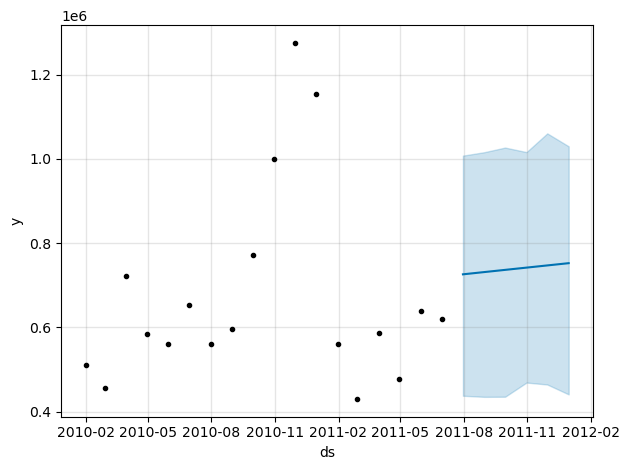

In [215]:
fig, ax = plt.subplots()
fig = model.plot(fcst, ax=ax);
plt.show()

Pretty awful since we used monthly data.  Let's try again with the full dataset of UK values.

In [229]:
fulluk = df[df.country == 'United Kingdom'][['invoicedate', 'revenue']]
cutoffdate = '2011-07-01'  # Gets another roughly 75-25 split

In [233]:
train = fulluk.loc[fulluk.invoicedate <= cutoffdate].copy()
test = fulluk.loc[fulluk.invoicedate > cutoffdate].copy()
train_proph = train.rename(columns={'invoicedate':'ds', 'revenue':'y'})
test_proph = test.rename(columns={'invoicedate':'ds', 'revenue':'y'})

In [235]:
model = Prophet()
model.fit(train_proph)

13:26:55 - cmdstanpy - INFO - Chain [1] start processing
13:27:38 - cmdstanpy - INFO - Chain [1] done processing


In [236]:
fcst = model.predict(test_proph)

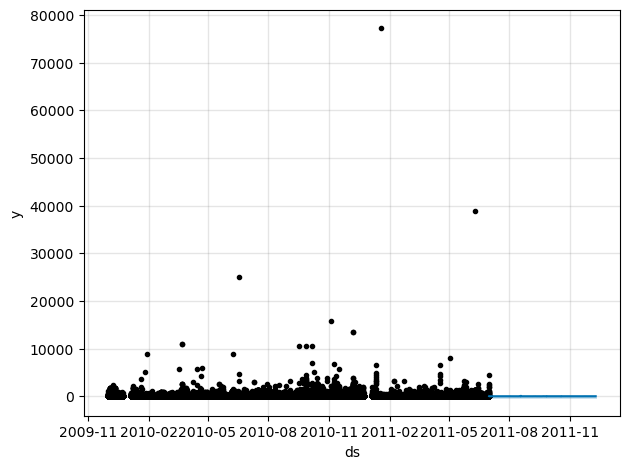

In [242]:
fig, ax = plt.subplots()
fig = model.plot(fcst, ax=ax);
plt.show();

Not very informative, but lets see how it actually predicts numerically by evaluating the model.  After this, we will try again while removing the outliers.

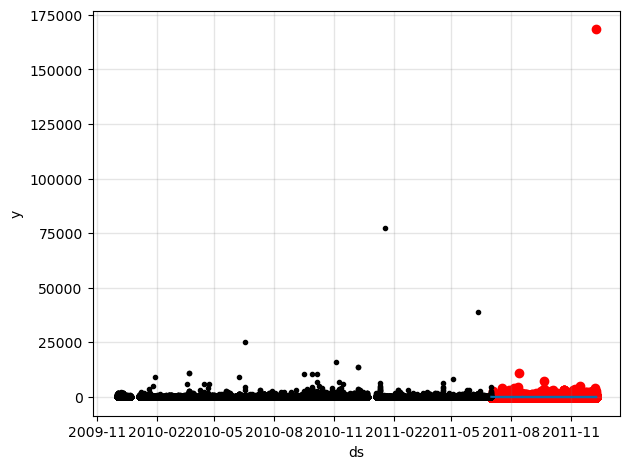

In [245]:
fig, ax = plt.subplots();
ax.scatter(test.invoicedate, test.revenue, color='r');
model.plot(fcst, ax=ax);
plt.show();

In [246]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [255]:
print(f"Our RMSE is: {np.sqrt(mean_squared_error(y_true=test.revenue, y_pred=fcst.yhat)):.3f} when using outliers")
print(f"Our MAE is: {mean_absolute_error(y_true=test.revenue, y_pred=fcst.yhat):.3f} when using outliers")
print(f"Our MAPE is: {np.mean(np.abs((np.array(test.revenue) - np.array(fcst.yhat)) / test.revenue)) * 100:.3f} when using outliers")

Our RMSE is: 335.130 when using outliers
Our MAE is: 20.290 when using outliers
Our MAPE is: 497.349 when using outliers


Our MAPE shows that this is a pretty awful forecaster.  Let's try again without the outliers.

In [265]:
# fulluk.revenue.quantile(q=[0, 0.25, 0.5, 0.75, 1])
IQR = fulluk.revenue.quantile(q=0.75) - fulluk.revenue.quantile(q=0.25)
nofulluk = fulluk[(fulluk.revenue > fulluk.revenue.quantile(q=0.25) - 1.5 * IQR) & (fulluk.revenue < fulluk.revenue.quantile(q=0.75) + 1.5 * IQR)]
# nofulluk.revenue.quantile(q=[0, 0.25, 0.5, 0.75, 1])
# nofulluk.head()  # full uk without any outliers

In [ ]:
train = nofulluk.loc[nofulluk.invoicedate <= cutoffdate].copy()
test = nofulluk.loc[nofulluk.invoicedate > cutoffdate].copy()
train_proph = train.rename(columns={'invoicedate':'ds', 'revenue':'y'})
test_proph = test.rename(columns={'invoicedate':'ds', 'revenue':'y'})

In [267]:
model = Prophet()
model.fit(train_proph)

13:49:13 - cmdstanpy - INFO - Chain [1] start processing
13:53:39 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
fcst = model.predict(test_proph)

In [ ]:
fig, ax = plt.subplots()
fig = model.plot(fcst, ax=ax);
plt.show();

In [ ]:
print(f"Our RMSE is: {np.sqrt(mean_squared_error(y_true=test.revenue, y_pred=fcst.yhat)):.3f} when using outliers")
print(f"Our MAE is: {mean_absolute_error(y_true=test.revenue, y_pred=fcst.yhat):.3f} when using outliers")
print(f"Our MAPE is: {np.mean(np.abs((np.array(test.revenue) - np.array(fcst.yhat)) / test.revenue)) * 100:.3f} when using outliers")